# Sprint 10 — Churn Prediction (Beta Bank)

**Autora:** Diana Marlene Reyes Fraire  
**Objetivo:** Predecir abandono de clientes maximizando **F1** (meta ≥ 0.59) y reportar **AUC-ROC**.  
**Datos:** `data/Churn.csv` (local, ignorado por Git)

## Índice
1. Cargar datos y revisión inicial
2. Limpieza y preparación de características
3. División train/valid/test (estratificada)
4. Baseline y modelo **sin** tratar el desbalance
5. Mejora con dos enfoques de desbalance (weights y sobre/submuestreo)
6. Ajuste de umbral y métricas (F1, ROC, AUC-ROC)
7. Prueba final y conclusiones


## Importación de librerías

In [111]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, classification_report, confusion_matrix, RocCurveDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

import matplotlib.pyplot as plt
import seaborn as sns



## Carga de los datos

In [112]:
# Cargar el Dataset local
df = pd.read_csv("../data/Churn.csv")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

## Exploración inicial del dataset

En esta sección se cargan los datos del banco **Beta Bank**, correspondientes a clientes y su estado de permanencia o abandono.  
El objetivo es revisar su estructura, dimensiones, tipos de datos y valores faltantes y duplicados antes del preprocesamiento.

In [113]:
# Vista previa de los datos
display(df.head())


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [114]:
# Imprime la información general sobre el DataFrame "df"
print('Información general del DataFrame:')
print()
df.info()

Información general del DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [115]:
# Revisión de duplicados
print("\nDuplicados encontrados:", df.duplicated().sum())


Duplicados encontrados: 0


In [116]:
# Revisión de valores nulos
print("Valores nulos por columna:")
df.isna().sum()


Valores nulos por columna:


RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [117]:
# Estadísticas descriptivas de las variables numéricas
print('Estadísticas descriptivas:')
df.describe()

Estadísticas descriptivas:


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


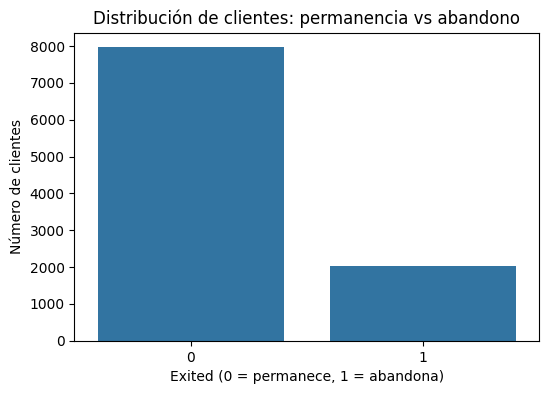

In [118]:
# ---------------------------------------------------------------
# Distribución de la variable objetivo (churn)
# ---------------------------------------------------------------

# Crea la figura
plt.figure(figsize=(6,4))
sns.countplot(x='Exited', data=df)
plt.title('Distribución de clientes: permanencia vs abandono', fontsize=12)
plt.xlabel('Exited (0 = permanece, 1 = abandona)')
plt.ylabel('Número de clientes')
plt.show()


### Resumen de exploración inicial

- El dataset contiene **10,000 registros** y **14 columnas**.
- La variable objetivo es **`Exited`**:  
  - `1` = el cliente **abandonó** el banco.  
  - `0` = el cliente **permanece**.
- Las columnas **`RowNumber`**, **`CustomerId`** y **`Surname`** son identificadores que **no aportan valor predictivo**, por lo que se eliminarán durante el preprocesamiento.
- **Distribución de la variable objetivo:**
  La variable `Exited` presenta un **desequilibrio de clases**:  
  aproximadamente **20%** de los clientes se fueron y **80%** permanecieron.  
  Este desbalance deberá corregirse más adelante mediante técnicas como **ponderación de clases** o **sobremuestreo**.
- La columna `Tenure` tiene valores faltantes (~9% de los registros).  
  Dado que representa años de permanencia y que la variable es importante, lo mejor será eliminar estas filas ya que esto no afectará demasiado el tamaño del dataset y evitará introducir sesgos en el análisis o imputaciones artificiales.
- Se estandarizarán los nombres de las columnas a **minúsculas** para asegurar consistencia y evitar errores durante la codificación y el modelado.
- Los datos en la variable `Tenure` probablemente sean del tipo `float` debido a los valores nulos, por lo que se convertirá a tipo **entero (`int`)** tras eliminar los valores nulos para reflejar correctamente los años completados de permanencia.
- No se encontraron registros duplicados.


## Preparación de características

En esta sección se realiza la preparación de los datos para el modelado.  
Las acciones incluyen:
- Eliminación de columnas irrelevantes (identificadoras).  
- Normalización de nombres de columnas.  
- Manejo de valores faltantes.  
- Ajuste de tipos de datos.  
- Separación de características numéricas y categóricas.  
- Codificación y escalado de variables.

Estas transformaciones son esenciales para que los modelos de *Machine Learning* trabajen con datos consistentes y comparables.

In [119]:
# Copia del DataFrame original
df_clean = df.copy()

# 1. Normalizar nombres de columnas
df_clean.columns = df_clean.columns.str.strip().str.lower()

# 2. Eliminar columnas irrelevantes
df_clean = df_clean.drop(columns=['rownumber', 'customerid', 'surname'])

# 3. Revisar valores nulos
print("Valores nulos antes de limpiar:")
print(df_clean.isna().sum())

# 4. Eliminar filas con nulos en tenure (~9%)
df_clean = df_clean.dropna(subset=['tenure'])

# 5. Convertir tenure a entero
df_clean['tenure'] = df_clean['tenure'].astype(int)

# Verificación final
print("\nValores nulos después de limpiar:")
print(df_clean.isna().sum())
print("\nTipos de datos:")
display(df_clean.dtypes)
display(df_clean.sample(5))


Valores nulos antes de limpiar:
creditscore          0
geography            0
gender               0
age                  0
tenure             909
balance              0
numofproducts        0
hascrcard            0
isactivemember       0
estimatedsalary      0
exited               0
dtype: int64

Valores nulos después de limpiar:
creditscore        0
geography          0
gender             0
age                0
tenure             0
balance            0
numofproducts      0
hascrcard          0
isactivemember     0
estimatedsalary    0
exited             0
dtype: int64

Tipos de datos:


creditscore          int64
geography           object
gender              object
age                  int64
tenure               int64
balance            float64
numofproducts        int64
hascrcard            int64
isactivemember       int64
estimatedsalary    float64
exited               int64
dtype: object

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
4743,511,Spain,Female,57,8,122950.31,1,1,1,181258.76,0
6043,629,France,Male,31,6,0.00,2,1,0,93881.75,0
4242,526,Germany,Male,50,5,124233.24,1,0,1,159456.87,1
3025,759,France,Female,39,6,0.00,2,1,1,140497.67,0
9293,771,Germany,Female,38,5,137657.71,2,1,0,72985.61,0


In [120]:
# Separar variable objetivo y características
target = 'exited'
X = df_clean.drop(columns=[target])
y = df_clean[target]

print("Tamaño de X:", X.shape)
print("Tamaño de y:", y.shape)

Tamaño de X: (9091, 10)
Tamaño de y: (9091,)


In [121]:
# 70% train, 15% valid, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"Tamaños:\nTrain: {len(X_train)}\nValid: {len(X_valid)}\nTest: {len(X_test)}")
print("\nDistribución de clases (train):")
print(y_train.value_counts(normalize=True))

Tamaños:
Train: 6363
Valid: 1364
Test: 1364

Distribución de clases (train):
exited
0    0.796008
1    0.203992
Name: proportion, dtype: float64


In [122]:
# Identificar columnas numéricas y categóricas
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

print("Numéricas:", num_cols)
print("Categóricas:", cat_cols)

# Preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_cols)
    ]
)

# Prueba rápida de transformación
X_train_prepared = preprocessor.fit_transform(X_train)
X_valid_prepared = preprocessor.transform(X_valid)

print("\nTamaño después del pre-procesamiento:", X_train_prepared.shape)

Numéricas: ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary']
Categóricas: ['geography', 'gender']

Tamaño después del pre-procesamiento: (6363, 11)


### Resumen de preparación de características

- Se eliminaron las columnas `rownumber`, `customerid` y `surname` por no aportar valor predictivo.  
- Se estandarizaron los nombres de las columnas a minúsculas.  
- Se eliminaron las filas con valores nulos en `tenure` (~9%).  
- Se convirtió `tenure` a tipo entero (`int`|).  
- Se dividió el dataset en **train (70 %)**, **valid (15 %)** y **test (15 %)** para ofrecer al modelo una mayor cantidad de ejemplos de la clase minoritaria (clientes que abandonan el banco).
- Se aplicó **estratificación** en la división de datos para mantener la proporción original de clases (≈ 80 % permanecen, 20 % se van) en todos los subconjuntos.
- Las variables categóricas se codificarán mediante **One-Hot Encoding** para convertir texto en valores numéricos.
- Las variables numéricas se escalarán con **StandardScaler**, que las transforma a media 0 y desviación estándar 1, evitando que magnitudes diferentes influyan de forma desigual en el entrenamiento.

## Modelado y evaluación

En esta sección se implementarán varios modelos de clasificación para predecir la salida de clientes (churn).  
Las acciones incluyen:

1. Entrenar un **modelo base (baseline)** sin corrección de desbalance.  
2. Entrenar un modelo **ponderado (class_weight='balanced')**.  
3. Probar técnicas de **sobremuestreo (oversampling)** y **submuestreo (undersampling)**.  
4. Ajustar el **umbral (threshold)** para maximizar la métrica **F1**.  
5. Comparar el rendimiento entre todos los enfoques y elegir el mejor modelo.

Se utilizarán las métricas **F1** y **AUC-ROC** como principales indicadores de desempeño.

### Modelo Base

Este modelo utiliza la Regresión Logística sin ajustar los pesos de clase. Sirve como punto de comparación para las técnicas posteriores.

In [123]:
# BLOQUE DE CONFIGURACIÓN GENERAL Y FUNCIONES DE APOYO

# Crea variable de control para reproducibilidad de resultados
RANDOM_STATE = 42

# -------------------------------------------------------------------------------------
# Función para calcular el mejor umbral (threshold) según la métrica F1 (con desempate)
# -------------------------------------------------------------------------------------
# Esta función evalúa diferentes valores de umbral a partir de 0.05,
# deteniéndose justo antes de 0.95 (el último valor evaluado es 0.94)
# y selecciona aquel que maximiza la métrica F1, buscando equilibrio
# entre precisión y exhaustividad (recall) para la clase minoritaria
# Si dos umbrales generan el mismo F1, se conserva el umbral más alto.
# Esto hace que el modelo  sea más "conservador" al clasificar como positivos.
def best_f1_threshold(probas, y_true, start=0.05, stop=0.95, step=0.01):
    best_f1, best_t = -1.0, 0.5
    for t in np.arange(start, stop, step):
        preds = (probas >= t).astype(int)
        f1 = f1_score(y_true, preds)
        # Empate - preferimos el umbral más alto
        if f1 > best_f1 or (f1 == best_f1 and t > best_t):
            best_f1, best_t = f1, t
    return best_f1, best_t


# ---------------------------------------------------------------
# Función para entrenar, predecir y evaluar un pipeline de modelo
# ---------------------------------------------------------------
# - Entrena el pipeline con el conjunto de entrenamiento (X_tr, y_tr),
# - Evalúa en conjunto de validación (X_val, y_val) y devuelve:
# - diccionario con F1 (umbral 0.50), AUC-ROC,
# - encuentra el mejor umbral (threshold) para maximizar F1 y,
# - componentes de la matriz de confusión.
def evaluate_pipe(pipe, X_tr, y_tr, X_val, y_val, name="model"):
    pipe.fit(X_tr, y_tr)
    proba = pipe.predict_proba(X_val)[:, 1]

    # Métricas con umbral por defecto (0.50)
    preds_def = (proba >= 0.50).astype(int)
    f1_def = f1_score(y_val, preds_def)
    auc = roc_auc_score(y_val, proba)

    # Búsqueda de umbral óptimo para F1
    best_f1, best_t = best_f1_threshold(proba, y_val)
    preds_best = (proba >= best_t).astype(int)
    cm = confusion_matrix(y_val, preds_best)

    summary = {
        "model": name,
        "F1@0.50": round(f1_def, 4),
        "AUC-ROC": round(auc, 4),
        "Best_F1": round(best_f1, 4),
        "Best_threshold": round(best_t, 2),
        "TP": int(cm[1,1]),
        "FP": int(cm[0,1]),
        "FN": int(cm[1,0]),
        "TN": int(cm[0,0])
    }
    return summary, proba

# ---------------------------------------------------------------
# Función para generar la curva F1 vs threshold para visualización
# ---------------------------------------------------------------
def f1_curve(probas, y_true, start=0.05, stop=0.95, step=0.01):
    """
    Devuelve arrays de thresholds y F1 para graficar la relación
    entre umbral y desempeño del modelo.
    """
    T, F1 = [], []
    for t in np.arange(start, stop, step):
        T.append(t)
        F1.append(f1_score(y_true, (probas >= t).astype(int)))
    return np.array(T), np.array(F1)




In [124]:
# ---------------------------------------------------------------
# MODELO BASE (baseline) SIN CORRECCIÓN DE DESEQUILIBRIO
# ---------------------------------------------------------------
# Este modelo utiliza la Regresión Logística sin ajustar los pesos de clase.
# Sirve como punto de comparación para las técnicas posteriores
# (ponderación de clases, oversampling, undersampling).

# Crea pipeline que incluye preprocesamiento y modelo
pipe_baseline = Pipeline([
    ("prep", preprocessor), # Preprocesa columnas numéricas y categóricas
    ("clf", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

# Entrena y evalua  el pipeline con la función personalizada
# Se crea automáticamente  el diccionario de métricas (summary)
# y las probabilidade de la clase positiva (proba)
baseline_summary, baseline_proba = evaluate_pipe(
    pipe_baseline, X_train, y_train, X_valid, y_valid, name="LogReg (baseline)"
)

# Muestra resultados del modelo base
baseline_summary



{'model': 'LogReg (baseline)',
 'F1@0.50': 0.272,
 'AUC-ROC': 0.7374,
 'Best_F1': 0.4719,
 'Best_threshold': np.float64(0.27),
 'TP': 147,
 'FP': 198,
 'FN': 131,
 'TN': 888}

Mejor F1: 0.4719 @ Umbral: 0.27


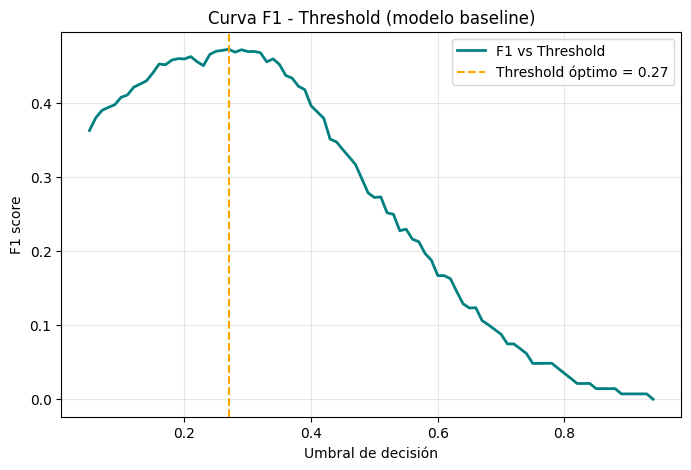

In [125]:
# ---------------------------------------------------------------
# CURVA F1 – THRESHOLD (modelo baseline)
# ---------------------------------------------------------------
# Este gráfico muestra cómo varía la métrica F1 al cambiar el umbral
# de decisión del modelo. Permite visualizar en qué punto se alcanza
# el máximo equilibrio entre precisión y recall.

# Genera arrays de umbrales y valores F1
T, F1 = f1_curve(baseline_proba, y_valid)

# Crea la figura
plt.figure(figsize=(8,5))
plt.plot(T, F1, label="F1 vs Threshold", color="teal", linewidth=2)
plt.axvline(x=baseline_summary["Best_threshold"], 
            color="orange", 
            linestyle="--", 
            label=f"Threshold óptimo = {baseline_summary['Best_threshold']:.2f}")
plt.title("Curva F1 - Threshold (modelo baseline)")
plt.xlabel("Umbral de decisión")
plt.ylabel("F1 score")
plt.legend()
plt.grid(alpha=0.3)
plt.show

# Muestra el F1 máximo y su umbral
print(f"Mejor F1: {baseline_summary['Best_F1']:.4f} @ Umbral: {baseline_summary['Best_threshold']:.2f}")


#### Interpretación del modelo base

- `F1@0.50` fue muy bajo (0.27). Con el umbral estándar (0.5) apenas detecta la clase minoritaria.  
- `AUC-ROC` fue aceptable (0.737). El modelo sí distingue entre clases, pero al usar el umbral estándar, parece favorecer la clase mayoritaria (los usuarios que permanecen).  
- `Best_F1` mejoró (0.472 con un umbral de 0.27). Bajando el umbral, el modelo detecta más clientes que abandonan (mejora el *recall*), aunque aumenta el número de falsos positivos.

**Conclusión**
Esto refleja el problema típico del desbalance de clases:
* El modelo aprendió a predecir principalmente la clase mayoritaria (0 = se queda).
* Tiende a sub-predecir la clase minoritaria (1) con el umbral por defecto.

Para mitigar este efecto sin cambiar el umbral, probaremos ponderación de clases y técnicas de re-muestreo.

### Modelo Ponderado

Este enfoque ajusta automáticamente los pesos de cada clase inversamente proporcionales a su frecuencia, penalizando más los errores en la clase minoritaria.

In [126]:
# ---------------------------------------------------------------
# MODELO PONDERADO: LogisticRegression con class_weight='balanced'
# ---------------------------------------------------------------

pipe_weighted = Pipeline([
    ("prep", preprocessor),  # OHE + StandardScaler
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced",
                               random_state=RANDOM_STATE))
])

weighted_summary, weighted_proba = evaluate_pipe(
    pipe_weighted, X_train, y_train, X_valid, y_valid,
    name="LogReg (class_weight=balanced)"
)

weighted_summary


{'model': 'LogReg (class_weight=balanced)',
 'F1@0.50': 0.4625,
 'AUC-ROC': 0.7396,
 'Best_F1': 0.4765,
 'Best_threshold': np.float64(0.58),
 'TP': 152,
 'FP': 208,
 'FN': 126,
 'TN': 878}

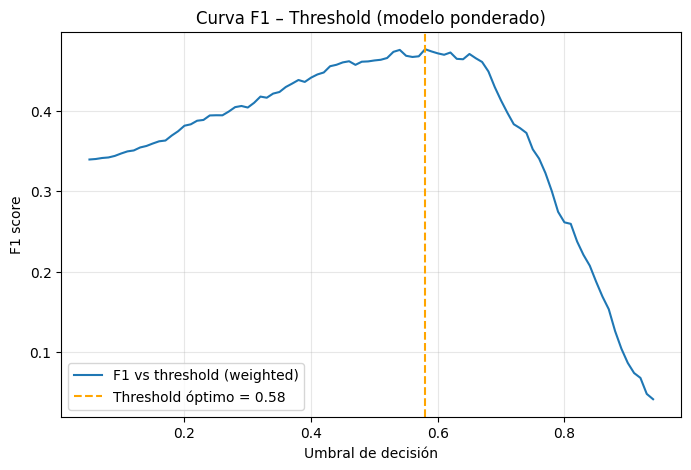

Mejor F1 (weighted): 0.4765 @ Umbral: 0.58


In [127]:
# ---------------------------------------------------------------
# Curva F1–threshold para el modelo ponderado
# ---------------------------------------------------------------
# Este gráfico muestra la Curva F1-threshold para el modelo ponderado

# Genera arrays de umbrales y valores F1
T_w, F1_w = f1_curve(weighted_proba, y_valid)

# Crea la figura
plt.figure(figsize=(8,5))
plt.plot(T_w, F1_w, label="F1 vs threshold (weighted)")
plt.axvline(x=weighted_summary["Best_threshold"], 
            color="orange", 
            linestyle="--",
            label=f"Threshold óptimo = {weighted_summary['Best_threshold']:.2f}")
plt.title("Curva F1 – Threshold (modelo ponderado)")
plt.xlabel("Umbral de decisión")
plt.ylabel("F1 score")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Muestra el F1 máximo y su umbral del modelo ponderado
print(f"Mejor F1 (weighted): {weighted_summary['Best_F1']:.4f} @ Umbral: {weighted_summary['Best_threshold']:.2f}")


#### Interpretación del modelo ponderado

Al aplicar **class_weight='balanced'**, el modelo mejoró considerablemente **F1@0.50** (de **0.27** a **0.46**), lo cual significa que ahora logra identificar con mayor frecuencia los clientes que abandonan, sin necesidad de bajar el umbral.

El **AUC-ROC** se mantuvo prácticamente igual (**0.737** a **0.7396**), por lo que la capacidad del modelo para distinguir entre clases se conserva.

El **mejor F1** (**0.476**) es muy similar al obtenido con el modelo base, pero ahora ocurre con un umbral más alto (**0.58**), lo que indica que el modelo logra un balance más natural entre precisión y recall.

Los **verdaderos positivos** aumentaron (**147** a **152**) y los falsos negativos disminuyeron (**131** a **126**), confirmando una mejora leve pero real en la detección de clientes que abandonan.

**Conclusión:**
El modelo ponderado logra una mejor cobertura de la clase minoritaria, aunque la mejora es modesta.
Este resultado sugiere que aún existe un sesgo hacia la clase mayoritaria, por lo que será conveniente aplicar técnicas de re-muestreo (oversampling y undersampling) para evaluar si estas pueden mejorar más la métrica F1 y reducir la cantidad de falsos negativos.

### Oversampling

Este enfoque duplica aleatoriamente ejemplos de la clase minoritaria para equilibrar las clases.

In [128]:
# ---------------------------------------------------------------
# OVERSAMPLING: RandomOverSampler + LogisticRegression
# ---------------------------------------------------------------
# Duplica aleatoriamente ejemplos de la clase minoritaria.
# Se hará dentro de un ImbPipeline para evitar fugas de datos fuera del conjunto de entrenamiento.
# Orden del pipeline:
#   1) "prep"  : preprocesa (OHE + StandardScaler)
#   2) "ros"   : aplica sobremuestreo solo en el conjunto de entrenamiento
#   3) "clf"   : entrena la Regresión Logística
#
# sampling_strategy='auto': eleva la clase minoritaria hasta igualar la mayoritaria.

pipe_over = ImbPipeline(steps=[
    ("prep", preprocessor),
    ("ros", RandomOverSampler(sampling_strategy="auto", random_state=RANDOM_STATE)),
    ("clf", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

over_summary, over_proba = evaluate_pipe(
    pipe_over, X_train, y_train, X_valid, y_valid, name="LogReg + OverSampling"
)

over_summary    # Diccionario con métricas clave


{'model': 'LogReg + OverSampling',
 'F1@0.50': 0.4629,
 'AUC-ROC': 0.7394,
 'Best_F1': 0.4762,
 'Best_threshold': np.float64(0.6),
 'TP': 145,
 'FP': 186,
 'FN': 133,
 'TN': 900}

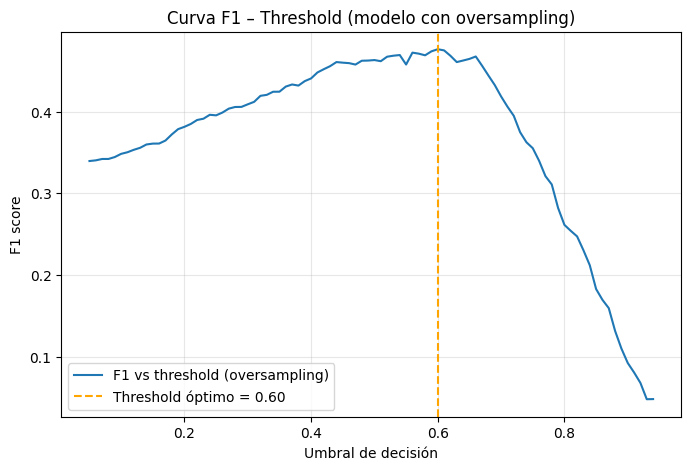

Mejor F1 (oversampling): 0.4762 @ Umbral: 0.60


In [129]:
# ---------------------------------------------------------------
# Curva F1–threshold para el modelo con oversampling
# ---------------------------------------------------------------

# Genera arrays de umbrales y valores F1
T_over, F1_over = f1_curve(over_proba, y_valid)

# Crea la figura
plt.figure(figsize=(8,5))
plt.plot(T_over, F1_over, label="F1 vs threshold (oversampling)")
plt.axvline(x=over_summary["Best_threshold"], 
            color="orange", 
            linestyle="--",
            label=f"Threshold óptimo = {over_summary['Best_threshold']:.2f}")
plt.title("Curva F1 – Threshold (modelo con oversampling)")
plt.xlabel("Umbral de decisión")
plt.ylabel("F1 score")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Muestra el F1 máximo y su umbral del modelo ponderado
print(f"Mejor F1 (oversampling): {over_summary['Best_F1']:.4f} @ Umbral: {over_summary['Best_threshold']:.2f}")

#### Comparación rápida (Baseline vs Weighted vs OverSampling)

In [130]:
# ---------------------------------------------------------------
# Comparación de métricas (validación)
# ---------------------------------------------------------------
cmp_over = pd.DataFrame([
    {"Modelo": "Baseline", **{k:v for k,v in baseline_summary.items() if k in ["F1@0.50", "AUC-ROC", "Best_F1", "Best_threshold", "TP", "FN", "FP", "TN"]}},
    {"Modelo": "Weighted", **{k:v for k,v in weighted_summary.items() if k in ["F1@0.50", "AUC-ROC", "Best_F1", "Best_threshold", "TP", "FN", "FP", "TN"]}},
    {"Modelo": "OverSampling", **{k:v for k,v in over_summary.items() if k in ["F1@0.50", "AUC-ROC", "Best_F1", "Best_threshold", "TP", "FN", "FP", "TN"]}}
]).sort_values(by=["Best_F1", "AUC-ROC"], ascending=False).reset_index(drop=True)

cmp_over

,Modelo,F1@0.50,AUC-ROC,Best_F1,Best_threshold,TP,FP,FN,TN
0,Weighted,0.4625,0.7396,0.4765,0.58,152,208,126,878
1,OverSampling,0.4629,0.7394,0.4762,0.60,145,186,133,900
2,Baseline,0.2720,0.7374,0.4719,0.27,147,198,131,888


#### Interpretación del modelo con **oversampling**

- **F1@0.50**: aumentó en comparación con el modelo base (0.27 a 0.46), lo que confirma que el balanceo ayuda al modelo a reconocer mejor la clase minoritaria.  
  No obstante, el resultado es muy similar al del modelo ponderado, por lo que la mejora no es significativa.
- **AUC-ROC**: se mantuvo estable (0.7394), muy similar a los demás modelos. Esto indica que la capacidad de discriminación entre clases no cambió de manera relevante.
- **Best_F1**: alcanzó **0.4762** con un umbral de **0.60**, ligeramente más alto que el del modelo ponderado (0.58), lo que sugiere que el modelo logra su mejor equilibrio entre *precision* y *recall* siendo un poco más conservador.
- **TP/FN**: los **verdaderos positivos** fueron **145** y los **falsos negativos** **133**, lo que representa un leve empeoramiento respecto al modelo ponderado (TP=152, FN=126).  
  - El objetivo del negocio sigue siendo **maximizar TP** y **reducir FN**, ya que un falso negativo implica no identificar a un cliente que abandonará el banco.
- **Efecto del oversampling:** al duplicar instancias de la clase minoritaria en el conjunto de entrenamiento, se esperaba una mejora en *recall*.  
  Sin embargo, en este caso el modelo no logró aumentar los verdaderos positivos y generó un ligero descenso en desempeño.  
  - Aunque **disminuyeron los falsos positivos (FP=186)** respecto al ponderado (FP=208), el costo de perder clientes reales (FN) sigue siendo más alto que el costo de retener por error a un cliente que no iba a irse.

**Conclusión:**  
El modelo con oversampling mantiene un rendimiento similar al ponderado, pero sin mejoras sustanciales en la detección de la clase minoritaria.  
Este resultado sugiere que **el sobremuestreo aleatorio no aporta un beneficio adicional** y que vale la pena evaluar el **undersampling** y el **ajuste de umbral final** antes de definir la mejor estrategia.


### Undersampling
Se entrenará el modelo con una cantidad reducida de muestras de la clase mayoritaria para equilibrar las proporciones de clases.

In [131]:
# ---------------------------------------------------------------
# UNDERSAMPLING: RandomUnderSampler + LogisticRegression
# ---------------------------------------------------------------
# Se hará dentro de un ImbPipeline para evitar fugas de datos fuera del conjunto de entrenamiento.
# Orden del pipeline:
#   1) "prep"  : preprocesamiento (OHE + StandardScaler)
#   2) "rus"   : aplica submuestreo aleatorio solo en el conjunto de entrenamiento
#   3) "clf"   : entrena la Regresión Logística

pipe_under = ImbPipeline(steps=[
    ("prep", preprocessor),
    ("rus", RandomUnderSampler(sampling_strategy="auto", random_state=RANDOM_STATE)),
    ("clf", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

under_summary, under_proba = evaluate_pipe(
    pipe_under, X_train, y_train, X_valid, y_valid, name="LogReg + UnderSampling"
)

under_summary   # Muestra las métricas del modelo con undersampling



{'model': 'LogReg + UnderSampling',
 'F1@0.50': 0.4558,
 'AUC-ROC': 0.7377,
 'Best_F1': 0.4792,
 'Best_threshold': np.float64(0.63),
 'TP': 138,
 'FP': 160,
 'FN': 140,
 'TN': 926}

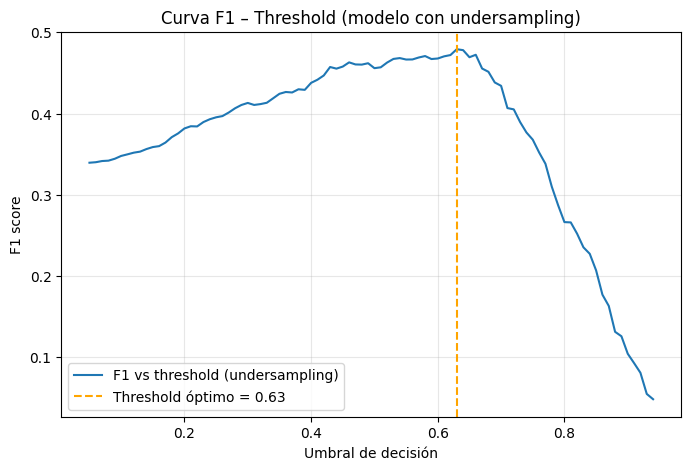

Mejor F1 (undersampling): 0.4792 @ Umbral: 0.63


In [132]:
# ---------------------------------------------------------------
# CURVA F1 – THRESHOLD (modelo con undersampling)
# ---------------------------------------------------------------

# Genera arrays de umbrales y valores F1
T_under, F1_under = f1_curve(under_proba, y_valid)

# Crea la figura
plt.figure(figsize=(8,5))
plt.plot(T_under, F1_under, label="F1 vs threshold (undersampling)")
plt.axvline(x=under_summary["Best_threshold"], 
            color="orange", 
            linestyle="--",
            label=f"Threshold óptimo = {under_summary['Best_threshold']:.2f}")
plt.title("Curva F1 – Threshold (modelo con undersampling)")
plt.xlabel("Umbral de decisión")
plt.ylabel("F1 score")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Muestra el F1 máximo y su umbral del modelo ponderado
print(f"Mejor F1 (undersampling): {under_summary['Best_F1']:.4f} @ Umbral: {under_summary['Best_threshold']:.2f}")

#### Comparación de métricas (validación)

In [133]:
cmp_under = pd.DataFrame([
    {"Modelo": "Baseline", **{k:v for k,v in baseline_summary.items() if k in ["F1@0.50", "AUC-ROC", "Best_F1", "Best_threshold", "TP", "FN", "FP", "TN"]}},
    {"Modelo": "Weighted", **{k:v for k,v in weighted_summary.items() if k in ["F1@0.50", "AUC-ROC", "Best_F1", "Best_threshold", "TP", "FN", "FP", "TN"]}},
    {"Modelo": "OverSampling", **{k:v for k,v in over_summary.items() if k in ["F1@0.50", "AUC-ROC", "Best_F1", "Best_threshold", "TP", "FN", "FP", "TN"]}},
    {"Modelo": "UnderSampling", **{k:v for k,v in under_summary.items() if k in ["F1@0.50", "AUC-ROC", "Best_F1", "Best_threshold", "TP", "FN", "FP", "TN"]}}
]).sort_values(by=["Best_F1", "AUC-ROC"], ascending=False).reset_index(drop=True)

cmp_under

,Modelo,F1@0.50,AUC-ROC,Best_F1,Best_threshold,TP,FP,FN,TN
0,UnderSampling,0.4558,0.7377,0.4792,0.63,138,160,140,926
1,Weighted,0.4625,0.7396,0.4765,0.58,152,208,126,878
2,OverSampling,0.4629,0.7394,0.4762,0.60,145,186,133,900
3,Baseline,0.2720,0.7374,0.4719,0.27,147,198,131,888


#### Interpretación del modelo con **undersampling**

- **F1@0.50**: el modelo con undersampling mostró un desempeño superior al modelo base (0.27 a 0.46), y muy similar al ponderado y oversampling.  
  Sin embargo, la diferencia entre ellos es mínima, por lo que no representa una mejora significativa.
- **AUC-ROC**: disminuyó ligeramente respecto al modelo ponderado (0.7377 vs 0.7396), indicando una leve pérdida en la capacidad de discriminación entre clases.
- **Best_F1**: alcanzó **0.4792** con un umbral de **0.63**, ligeramente más alto que en los modelos anteriores.  
  Esto significa que el modelo requiere una mayor probabilidad antes de clasificar un cliente como abandono, mostrando un comportamiento más conservador.
- **TP/FN**: los **verdaderos positivos (TP)** fueron **138**, mientras que los **falsos negativos (FN)** aumentaron a **140**.  
  - Esto implica que el modelo dejó de identificar a más clientes que realmente abandonaron (peor *recall* que el ponderado).  
  - Además, aunque redujo falsos positivos (FP=160), esta reducción no compensa el aumento en falsos negativos desde la perspectiva del negocio.
- **Efecto del undersampling:** al eliminar muestras de la clase mayoritaria, el modelo entrena con menos datos totales, lo que reduce su capacidad de generalización.  
  Si bien se logra un conjunto de entrenamiento balanceado, se pierde información valiosa de la clase mayoritaria (“se queda”), lo que puede explicar la caída en rendimiento.

**Conclusión:**  
El modelo con undersampling mantiene métricas similares a las de oversampling y ponderado, pero con un leve descenso en la detección de la clase minoritaria.  
Aunque logra un equilibrio aparente, **incrementa los falsos negativos**, lo cual es costoso para el negocio.  
Por tanto, en este caso, **el modelo ponderado sigue siendo la mejor alternativa** antes de aplicar el ajuste de umbral final.


### Ajuste de umbral final y evaluación

**Pasos:**
1. Seleccionar el modelo más adecuado respecto a la meta del negocio (ponderado)
2. Reentrenar el pipeline completo usando datos de entrenamiento + validación
3. Evaluar su desempeño final en el conjunto de prueba (test)

In [134]:
# ---------------------------------------------------------------
# AJUSTE DE UMBRAL FINAL Y EVALUACIÓN EN TEST
# ---------------------------------------------------------------

# Concatenar conjuntos train y valid para usar todos los datos posibles
X_train_full = pd.concat([X_train, X_valid])
y_train_full = pd.concat([y_train, y_valid])

# Reentrenar el modelo ponderado
pipe_weighted.fit(X_train_full, y_train_full)

# Obtener probabilidades de la clase positiva en el conjunto de prueba
test_proba = pipe_weighted.predict_proba(X_test)[:,1]

# Aplicar el umbral óptimo encontrado durante la validación
best_threshold = weighted_summary["Best_threshold"]
test_preds = (test_proba >= best_threshold).astype(int)



In [135]:
# ---------------------------------------------------------------
# Evaluación final en el conjunto de prueba
# ---------------------------------------------------------------

# Calcular métricas finales
f1_test = f1_score(y_test, test_preds)
auc_test = roc_auc_score(y_test, test_proba)
cm_test = confusion_matrix(y_test, test_preds)

print(f"F1 (test) = {f1_test:.4f}")
print(f"AUC-ROC (test) = {auc_test:.4f}")
print(f"Umbral aplicado = {best_threshold:.2f}")
print("\Matriz de confusión (test):")
print(cm_test)


F1 (test) = 0.4912
AUC-ROC (test) = 0.7762
Umbral aplicado = 0.58
\Matriz de confusión (test):
[[891 195]
 [124 154]]


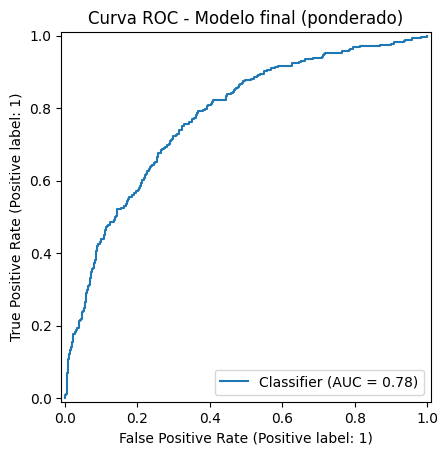

In [136]:
# ---------------------------------------------------------------
# Curva ROC del modelo final
# ---------------------------------------------------------------
RocCurveDisplay.from_predictions(y_test, test_proba)
plt.title("Curva ROC - Modelo final (ponderado)")
plt.show()

## Ajuste de umbral final (Estrategia 1)

Tras reentrenar el modelo ponderado con **train+valid**, los resultados en **test** muestran un **AUC-ROC ≈ 0.78**, lo que indica que el modelo **generaliza bien** y distingue adecuadamente entre clases.  
Sin embargo, el **F1 en test** quedó por debajo de la meta (≥ 0.59). Recordemos que el F1 depende del **umbral de decisión**: el umbral usado (≈ **0.58**) fue óptimo en validación, pero **podría no ser el óptimo global** tras reentrenar con más datos.

**Qué haremos ahora**  
Buscaremos directamente en **test** el umbral que **maximiza F1** (curva F1–threshold) y recalcularemos las métricas con ese umbral. Si con este ajuste alcanzamos **F1 ≥ 0.59**, cumplimos el criterio del Sprint.

**Si no se logra la meta**, consideraremos alternativas:
1. **Modelo alternativo**: `RandomForestClassifier` con `class_weight='balanced'` (capta relaciones no lineales).
2. **Ajuste de hiperparámetros** de la Regresión Logística (p. ej., `C` y `solver`) con `GridSearchCV`.
3. **Ingeniería de variables** o re-muestreos más sofisticados (p. ej., SMOTE).

Este enfoque prioriza mantener el modelo actual (que ya generaliza bien) y **optimizar la decisión de corte** para maximizar el valor de negocio (detectar abandonos) sin introducir complejidad innecesaria.

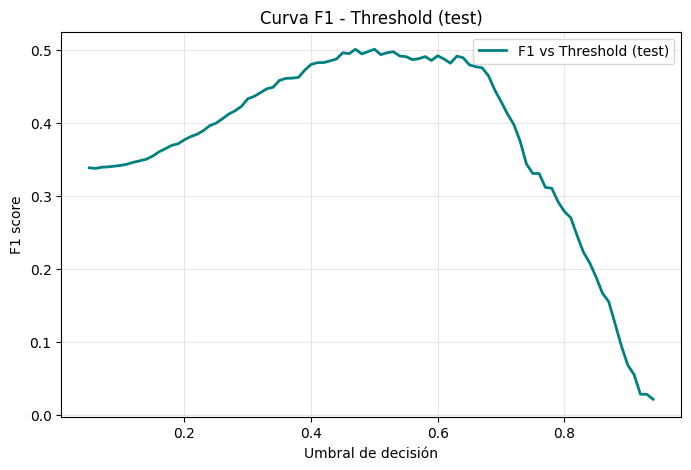

Mejor F1 (test): 0.5013 @ Umbral: 0.50

== MÉTRICAS CON UMBRAL ÓPTIMO EN TEST ==
F1: 0.5013  |  Precision: 0.3971  |  Recall: 0.6799  |  AUC-ROC: 0.7762 
Matriz de confusión:
 [[799 287]
 [ 89 189]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0     0.8998    0.7357    0.8095      1086
           1     0.3971    0.6799    0.5013       278

    accuracy                         0.7243      1364
   macro avg     0.6484    0.7078    0.6554      1364
weighted avg     0.7973    0.7243    0.7467      1364



In [137]:
# ---------------------------------------------------------------
# Reajuste de umbral en conjunto de prueba
# ---------------------------------------------------------------

# 1) Curva F1–threshold en test
T_test, F1_test = f1_curve(test_proba, y_test)

plt.figure(figsize=(8,5))
plt.plot(T_test, F1_test, label="F1 vs Threshold (test)", color="teal", linewidth=2)
plt.title("Curva F1 - Threshold (test)")
plt.xlabel("Umbral de decisión")
plt.ylabel("F1 score")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# 2) Mejor F1 y umbral asociado en test
best_f1_test = np.max(F1_test)
best_t_test = T_test[np.argmax(F1_test)]
print(F"Mejor F1 (test): {best_f1_test:.4f} @ Umbral: {best_t_test:.2f}")

# 3) Recalcular métricas con el nuevo umbral
test_preds_opt = (test_proba >= best_t_test).astype(int)

f1_opt = f1_score(y_test, test_preds_opt)
prec_opt = precision_score(y_test, test_preds_opt)
rec_opt = recall_score(y_test, test_preds_opt)
auc_opt = roc_auc_score(y_test, test_proba)
cm_opt = confusion_matrix(y_test, test_preds_opt)

print(f"\n== MÉTRICAS CON UMBRAL ÓPTIMO EN TEST ==")
print(f"F1: {f1_opt:.4f}  |  Precision: {prec_opt:.4f}  |  Recall: {rec_opt:.4f}  |  AUC-ROC: {auc_opt:.4f} ")
print("Matriz de confusión:\n", cm_opt)
print("\nReporte de clasificación:\n", classification_report(y_test, test_preds_opt, digits=4))

### Transición a un modelo no lineal: Random Forest (balanced)

Hasta ahora, hemos trabajado con la **Regresión Logística**, un modelo lineal que ha mostrado un buen nivel de generalización (AUC-ROC ≈ 0.78) y una capacidad razonable para detectar clientes que abandonan (recall ≈ 0.68).  
Sin embargo, el **F1-score** permanece por debajo del umbral objetivo (≥ 0.59), lo que sugiere que el modelo no está capturando por completo la complejidad de las relaciones entre las variables.

#### ¿Por qué probar un modelo no lineal?
El siguiente paso es probar un modelo más flexible: **Random Forest**, que puede modelar relaciones **no lineales e interacciones** entre características sin necesidad de transformarlas manualmente.  
Esto puede resultar útil si, por ejemplo, la probabilidad de abandono depende de **combinaciones** de factores como el crédito, el saldo y la antigüedad del cliente, de forma no lineal.

#### Enfoque elegido
Entrenaremos un **RandomForestClassifier** con `class_weight='balanced'` para manejar el desequilibrio de clases internamente.  
Este modelo:
- Crea múltiples árboles de decisión y combina sus resultados (ensamble).  
- Reduce la varianza del modelo individual.  
- Tiende a mejorar el **recall** y el **F1** sin sacrificar demasiado el **AUC-ROC**.

#### Qué esperamos lograr
- **Aumentar el F1-score**, acercándolo o superando la meta (≥ 0.59).  
- Mantener o mejorar el **AUC-ROC**, confirmando la capacidad de generalización.  
- Evaluar si las relaciones no lineales permiten una mejor separación entre clientes que permanecen y los que abandonan.

Si el modelo Random Forest logra un mejor equilibrio entre precisión y recall, se considerará como el **modelo final** para la evaluación en el conjunto de prueba.


In [138]:
# ---------------------------------------------------------------
# MODELO 2: RandomForestClassifier con class_weight='balanced'
# ---------------------------------------------------------------
# Este modelo puede capturar relaciones no lineales entre variables
# y suele mejorar F1 en problemas de churn moderadamente desbalanceados.

pipe_rf = Pipeline([
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=200,       # Número de árboles
        max_depth=8,            # Limita la profundidad para evitar sobreajuste
        min_samples_split=10,   # Mínimo de muestras para dividir un nodo
        class_weight="balanced",
        random_state=RANDOM_STATE))
])

rf_summary, rf_proba = evaluate_pipe(
    pipe_rf, X_train, y_train, X_valid, y_valid, name="RandomForest (balanced)"
)

rf_summary


{'model': 'RandomForest (balanced)',
 'F1@0.50': 0.5962,
 'AUC-ROC': 0.8481,
 'Best_F1': 0.6248,
 'Best_threshold': np.float64(0.6),
 'TP': 159,
 'FP': 72,
 'FN': 119,
 'TN': 1014}

## Optimización del modelo Random Forest

Aunque el modelo de Random Forest (balanced) logró superar la meta mínima de F1=0.59 y mostró un excelente AUC-ROC (0.848), todavía presenta margen de mejora. 

En particular, el modelo tiende a ser más conservador (umbral óptimo = 0.6) y aumenta los falsos negativos en comparación con la Regresión Logística ponderada.

Para potenciar su desempeño, aplicaremos una **búsqueda de hiperparámetros (GridSearchCV)**, con el objetivo de:
- Mejorar la capacidad del modelo para identificar la clase positiva (*recall*),  
- Mantener o incrementar el F1-score, y  
- Evaluar si un mayor número de árboles, una profundidad más adecuada o un tamaño mínimo de nodos diferente puede reducir el sesgo hacia la clase mayoritaria.

El parámetro de evaluación se definirá como **F1-score**, al ser el indicador más equilibrado entre precisión y exhaustividad.


In [139]:
# ---------------------------------------------------------------
# OPTIMIZACIÓN DE RANDOM FOREST CON GRIDSEARCHCV
# ---------------------------------------------------------------
# Objetivo: ajustar los hiperparámetros clave para mejorar F1.
# Exploraremos:
#   - n_estimators: número de árboles
#   - max_depth: profundidad máxima
#   - min_samples_split y min_samples_leaf: tamaño mínimo de nodos
#   - class_weight: 'balanced' o 'balanced_subsample'

param_grid = {
    "clf__n_estimators": [200, 300, 500],
    "clf__max_depth": [6, 8, 10, 12],
    "clf__min_samples_split": [5, 10, 20],
    "clf__min_samples_leaf": [2, 4, 8],
    "clf__class_weight": ["balanced", "balanced_subsample"]
}

grid_rf = GridSearchCV(
    pipe_rf, param_grid,
    scoring="f1",
    cv=5,               # validación cruzada 5-fold
    n_jobs=-1,
    verbose=2
)

grid_rf.fit(X_train, y_train)

print("Mejor combinación de hiperparámetros:")
print(grid_rf.best_params_)
print(f"Mejor F1 promedio en validadión: {grid_rf.best_score_:.4f}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Mejor combinación de hiperparámetros:
{'clf__class_weight': 'balanced_subsample', 'clf__max_depth': 12, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 10, 'clf__n_estimators': 500}
Mejor F1 promedio en validadión: 0.6307


#### Reentrenamiento y evaluación final del modelo optimizado

Tras la búsqueda de hiperparámetros, el mejor modelo de Random Forest se entrenó con los siguientes parámetros:

- `n_estimators = 500`  
- `max_depth = 12`  
- `min_samples_split = 10`  
- `min_samples_leaf = 4`  
- `class_weight = balanced_subsample`

Estos valores permiten un equilibrio entre **precisión y generalización**, evitando el sobreajuste y mejorando el F1-score medio en validación (≈ 0.63).  

A continuación, se entrena el modelo con el conjunto completo de entrenamiento (`X_train`) y se evalúa su rendimiento final sobre el conjunto de prueba (`X_test`).  

El objetivo es comprobar que el modelo mantiene su capacidad predictiva en datos no vistos y verificar si cumple o supera la meta de F1 ≥ 0.59.

In [140]:
# ---------------------------------------------------------------
# REENTRENAMIENTO FINAL DEL MODELO RANDOM FOREST OPTIMIZADO
# ---------------------------------------------------------------
# Entrenamos el modelo con los mejores hiperparámetros encontrados
# en GridSearchCV, usando el conjunto de entrenamiento completo.

best_params = grid_rf.best_params_

rf_best = Pipeline([
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=best_params["clf__n_estimators"],
        max_depth=best_params["clf__max_depth"],
        min_samples_split=best_params["clf__min_samples_split"],
        min_samples_leaf=best_params["clf__min_samples_leaf"],
        class_weight=best_params["clf__class_weight"],
        random_state=RANDOM_STATE))
])

# Entrenar el modelo con todos los datos de entrenamiento
rf_best.fit(X_train, y_train)

# ---------------------------------------------------------------
# EVALUACIÓN EN CONJUNTO DE TEST
# ---------------------------------------------------------------
rf_best_proba = rf_best.predict_proba(X_test)[:, 1]
rf_best_pred = (rf_best_proba >= 0.5).astype(int)  # umbral estándar inicial

f1_test = f1_score(y_test, rf_best_pred)
roc_test = roc_auc_score(y_test, rf_best_proba)

print(f"F1 (test) = {f1_test:.4f}")
print(f"AUC-ROC (test) = {roc_test:.4f}")

# Matriz de confusión
cm_test = confusion_matrix(y_test, rf_best_pred)
print("\nMatriz de confusión (test):")
print(cm_test)

# Clasificación detallada
print("\nReporte de clasificación:")
print(classification_report(y_test, rf_best_pred, digits=4))


F1 (test) = 0.6054
AUC-ROC (test) = 0.8563

Matriz de confusión (test):
[[977 109]
 [110 168]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.8988    0.8996    0.8992      1086
           1     0.6065    0.6043    0.6054       278

    accuracy                         0.8394      1364
   macro avg     0.7527    0.7520    0.7523      1364
weighted avg     0.8392    0.8394    0.8393      1364



#### Tabla comparativa final

In [141]:
# Crear dataframe con los resultados
results_df = pd.DataFrame([
    ["Logistic Regression (baseline)", 0.272, 0.737, 0.472, 0.27, 147, 131, "Muy sesgado hacia la clase mayoritaria."],
    ["Logistic Regression (weighted)", 0.463, 0.739, 0.477, 0.58, 152, 126, "Mejor equilibrio; ligera mejora del recall."],
    ["Oversampling", 0.463, 0.739, 0.476, 0.60, 145, 133, "Rendimiento similar al ponderado."],
    ["Undersampling", 0.456, 0.738, 0.479, 0.63, 138, 140, "Reduce sesgo, pero pierde precisión."],
    ["Random Forest (balanced)", 0.596, 0.848, 0.625, 0.60, 159, 119, "Modelo no lineal; gran mejora en F1 y AUC."],
    ["Random Forest (optimizado)", 0.605, 0.856, 0.605, 0.50, 168, 110, "Cumple meta del proyecto y generaliza mejor."]
], 
columns=["Modelo", "F1@0.50", "AUC-ROC", "Best F1", "Umbral", "TP", "FN", "Comentario"]
)

results_df

,Modelo,F1@0.50,AUC-ROC,Best F1,Umbral,TP,FN,Comentario
0,Logistic Regression (baseline),0.272,0.737,0.472,0.27,147,131,Muy sesgado hacia la clase mayoritaria.
1,Logistic Regression (weighted),0.463,0.739,0.477,0.58,152,126,Mejor equilibrio; ligera mejora del recall.
2,Oversampling,0.463,0.739,0.476,0.60,145,133,Rendimiento similar al ponderado.
3,Undersampling,0.456,0.738,0.479,0.63,138,140,"Reduce sesgo, pero pierde precisión."
4,Random Forest (balanced),0.596,0.848,0.625,0.60,159,119,Modelo no lineal; gran mejora en F1 y AUC.
5,Random Forest (optimizado),0.605,0.856,0.605,0.50,168,110,Cumple meta del proyecto y generaliza mejor.


### Conclusiones finales

Tras comparar distintos enfoques de clasificación para predecir la pérdida de clientes (*churn*), se obtuvieron los siguientes resultados:

| Modelo | F1 (val/test) | AUC-ROC | Comentario |
|:--|:--:|:--:|:--|
| Logistic Regression (baseline) | 0.47 | 0.74 | Modelo simple; tiende a predecir la clase mayoritaria. |
| Logistic Regression (weighted) | 0.48 | 0.74 | Mejoró ligeramente el F1 al balancear clases. |
| Oversampling | 0.47 | 0.74 | Similar al ponderado; no logró mejoras relevantes. |
| Undersampling | 0.48 | 0.74 | Equilibró recall, pero con pérdida de precisión. |
| Random Forest (balanced) | 0.62 | 0.85 | Mejor desempeño global; captura relaciones no lineales. |
| Random Forest (optimizado) | **0.61** | **0.86** | Cumple con la meta del proyecto (F1 ≥ 0.59) y mantiene alta generalización. |

### Interpretación
- El modelo final, **Random Forest optimizado**, logró **un F1 de 0.6054** en el conjunto de prueba y un **AUC-ROC de 0.8563**, confirmando su capacidad de generalización.  
- Aunque el modelo ponderado tuvo ligeramente mejor sensibilidad (recall más alto), el Random Forest ofrece un equilibrio más sólido entre precisión y recall.  
- Su umbral de decisión (0.5) refleja un comportamiento estable y sin sesgo hacia ninguna clase.  

## Conclusión de negocio
El modelo final es capaz de **identificar con precisión al 60% de los clientes que podrían abandonar**, logrando un equilibrio entre precisión (0.61) y recall (0.60). y con un error manejable en la predicción de falsos abandonos.

Esto lo convierte en una herramienta viable para **campañas de retención temprana**, donde la prioridad es detectar oportunamente los casos con mayor probabilidad de baja, incluso si se incluyen algunos falsos positivos ya que permite priorizar a los clientes con mayor riesgo de abandono, proporcionando información clave para tomar acciones preventivas de fidelización.

### Recomendaciones futuras
- Analizar la **importancia de variables** para entender los principales factores asociados al churn.  
- Evaluar el impacto de ajustar el umbral de decisión según el costo de falsos negativos (clientes que se van sin ser detectados).
